In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf
import cv2
import numpy as np
import keras
from pathlib import Path

In [ ]:
imagenette_builder = tfds.builder("imagenette/160px-v2")
imagenette_info = imagenette_builder.info
imagenette_builder.download_and_prepare()
datasets = imagenette_builder.as_dataset(as_supervised=True, batch_size=-1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/imagenette/160px-v2/1.0.0.incomplete3XOW7Y/imagenette-train.tfrecord*...: …

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/160px-v2/1.0.0.incomplete3XOW7Y/imagenette-validation.tfrecord*…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/160px-v2/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# (training_data, test_data), info = tfds.load("imagenette/160px-v2", with_info=True, shuffle_files=True, as_supervised=True, split=['train', 'validation'])

In [ ]:
train_dataset, test_dataset = datasets['train'], datasets['validation']

In [ ]:
for example in tfds.as_numpy(train_dataset[0]):
    train_image = cv2.resize(example, (128, 128))
train_label = []
for example in tfds.as_numpy(train_dataset[1]):
    train_label.append(example)

for example in tfds.as_numpy(test_dataset[0]):
    val_image = cv2.resize(example, (128, 128))
val_label = []
for example in tfds.as_numpy(test_dataset[1]):
    val_label.append(example)

In [ ]:
def load_images_and_labels(KEY):
    ds = datasets[KEY]
    image_list = []
    label_list = []
    for index in range(len(ds[0])):
        img =  tfds.as_numpy(ds[0][index])
        resized_img = cv2.resize(img, (128, 128))
        img_arr = np.array(resized_img)
        image_list.append(np.round(img_arr/255., 5))
        label_list.append(tfds.as_numpy(ds[1][index]))
    image_list = np.asarray(image_list)
    label_list = np.asarray(label_list)
    return image_list, label_list

train_images, train_labels = load_images_and_labels('train')
test_and_val_images, test_and_val_labels = load_images_and_labels('validation')

In [ ]:
print(train_images.shape)
print(test_and_val_images.shape)

(9469, 128, 128, 3)
(3925, 128, 128, 3)


In [ ]:
data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/data"
np.save(Path(data_path, "train_images"), train_images)
np.save(Path(data_path, "train_labels"), train_labels)
np.save(Path(data_path, "test_and_val_images"), test_and_val_images)
np.save(Path(data_path, "test_and_val_labels"), test_and_val_labels)

In [6]:
data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/data"
train_images = np.load(Path(data_path, "train_images.npy"))
train_labels = np.load(Path(data_path, "train_labels.npy"))
test_and_val_images = np.load(Path(data_path, "test_and_val_images.npy"))
test_and_val_labels = np.load(Path(data_path, "test_and_val_labels.npy"))

In [7]:
from sklearn.model_selection import train_test_split
# Split into test and validation sets
test_images, val_images, test_labels, val_labels = train_test_split(test_and_val_images, test_and_val_labels, test_size=0.4, random_state=12)

In [8]:
train_labels_onehot = keras.utils.to_categorical(train_labels, 10)
test_labels_onehot = keras.utils.to_categorical(test_labels, 10)
val_labels_onehot = keras.utils.to_categorical(val_labels, 10)


print('Labels train shape: {}'.format(train_labels_onehot.shape))

Labels train shape: (9469, 10)


In [9]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

Images train shape: (9469, 128, 128, 3) - Labels train shape: (9469,)
Images validation shape: (1570, 128, 128, 3) - Labels validation shape: (1570,)
Images test shape: (2355, 128, 128, 3) - Labels test shape: (2355,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.02781049696770004
Data type float64


In [10]:
from tensorflow.keras.applications import vgg16
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(10, activation='softmax')(x)

# The model we will train
nette_vgg16 = Model(inputs=base_model.input, outputs=predictions)
nette_vgg16.compile(#optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
!git clone https://github.com/WittmannF/LRFinder.git

Cloning into 'LRFinder'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Unpacking objects: 100% (71/71), 447.00 KiB | 4.03 MiB/s, done.


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
#from LRFinder.keras_callback import LRFinder

#lr_finder = LRFinder(min_lr=1e-8, max_lr=1e-5)
PATIENCE = 10
callbacks = [EarlyStopping(monitor='val_loss',
                   patience = PATIENCE,
                   restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
             #LRFinder(min_lr=1e-6, max_lr=1e-3)
            ]



In [12]:

history = nette_vgg16.fit(x= train_images,
    y= train_labels_onehot,
    batch_size=64,
    epochs=50,
    # monitoring validation loss and metrics
    validation_data=(val_images, val_labels_onehot),
    verbose=1,
    callbacks=callbacks
)


Epoch 1/50
148/148 [==============================] - 20s 59ms/step - loss: 2.0410 - accuracy: 0.2719 - val_loss: 1.3131 - val_accuracy: 0.5618 - lr: 1.0000e-05
Epoch 2/50
148/148 [==============================] - 6s 43ms/step - loss: 1.3027 - accuracy: 0.5831 - val_loss: 1.1120 - val_accuracy: 0.6338 - lr: 1.0000e-05
Epoch 3/50
148/148 [==============================] - 6s 43ms/step - loss: 1.0723 - accuracy: 0.6590 - val_loss: 0.9144 - val_accuracy: 0.6904 - lr: 1.0000e-05
Epoch 4/50
148/148 [==============================] - 6s 43ms/step - loss: 0.9353 - accuracy: 0.6958 - val_loss: 0.8772 - val_accuracy: 0.7255 - lr: 1.0000e-05
Epoch 5/50
148/148 [==============================] - 6s 43ms/step - loss: 0.8385 - accuracy: 0.7309 - val_loss: 0.8415 - val_accuracy: 0.7408 - lr: 1.0000e-05
Epoch 6/50
148/148 [==============================] - 6s 43ms/step - loss: 0.7770 - accuracy: 0.7476 - val_loss: 0.9874 - val_accuracy: 0.7006 - lr: 1.0000e-05
Epoch 7/50
148/148 [===================

In [16]:
for item in history.items():
    print(item)

AttributeError: ignored

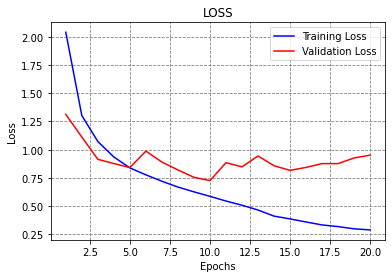

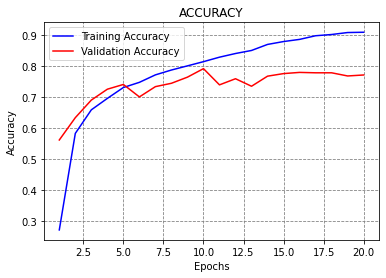

In [19]:
import matplotlib.pyplot as plt
# Plot the loss and accuracy

train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')


axes = plt.gca()

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()            
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()